_Lambda School Data Science — Tree Ensembles_ 

# Model Interpretation

### Objectives
- Partial Dependence Plots
- Shapley Values


### Pre-reads
1. Kaggle / Dan Becker: Machine Learning Explainability
  - https://www.kaggle.com/dansbecker/partial-plots
  - https://www.kaggle.com/dansbecker/shap-values
2. Christoph Molnar: Interpretable Machine Learning
  - https://christophm.github.io/interpretable-ml-book/pdp.html
  - https://christophm.github.io/interpretable-ml-book/shapley.html 


### Libraries
- [PDPbox](https://github.com/SauceCat/PDPbox): `pip install pdpbox`
- [shap](https://github.com/slundberg/shap): `conda install -c conda-forge shap` / `pip install shap`

  
### Types of explanations

#### Global explanation: all features in relation to each other
- Feature Importances (mean decrease impurity)
- Permutation Importances
- Drop-Column Importances

#### Global explanation: individual feature in relation to target
- Partial Dependence plots

#### Individual prediction explanation
- Shapley Values

_Note that the coefficients from a linear model give you all three types of explanations!_

# Titanic

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

def load_titanic():
    df = sns.load_dataset('titanic')
    df['age'] = df['age'].fillna(df['age'].mean())
    df['class'] = df['class'].map({'First': 1, 'Second': 2, 'Third': 3})
    df['female'] = df['sex'] == 'female'
    X = df[['age', 'class', 'fare', 'female']]
    y = df['survived']
    return X, y

X, y = load_titanic()

#### Naive majority class baseline

In [2]:
y.value_counts(normalize=True)

0    0.616162
1    0.383838
Name: survived, dtype: float64

#### Logistic Regression

In [3]:
lr = LogisticRegression(solver='lbfgs')
cross_val_score(lr, X, y, scoring='accuracy', cv=5, n_jobs=-1)

array([0.7877095 , 0.78212291, 0.78651685, 0.7752809 , 0.80225989])

In [4]:
lr.fit(X, y)
pd.Series(lr.coef_[0], X.columns)

age      -0.032595
class    -1.112937
fare      0.000805
female    2.512794
dtype: float64

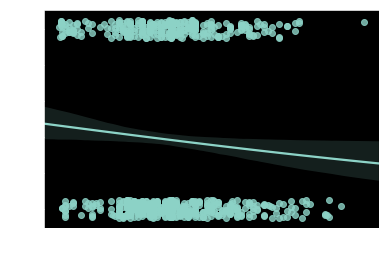

In [5]:
sns.regplot(x=X['age'], y=y, logistic=True, y_jitter=.05);

#### Gradient Boosting

In [6]:
gb = GradientBoostingClassifier()
cross_val_score(gb, X, y, scoring='accuracy', cv=5, n_jobs=-1)

array([0.80446927, 0.82681564, 0.85393258, 0.83146067, 0.84745763])

In [7]:
gb.fit(X, y)
pd.Series(gb.feature_importances_, X.columns)

age       0.131601
class     0.173700
fare      0.199391
female    0.495308
dtype: float64

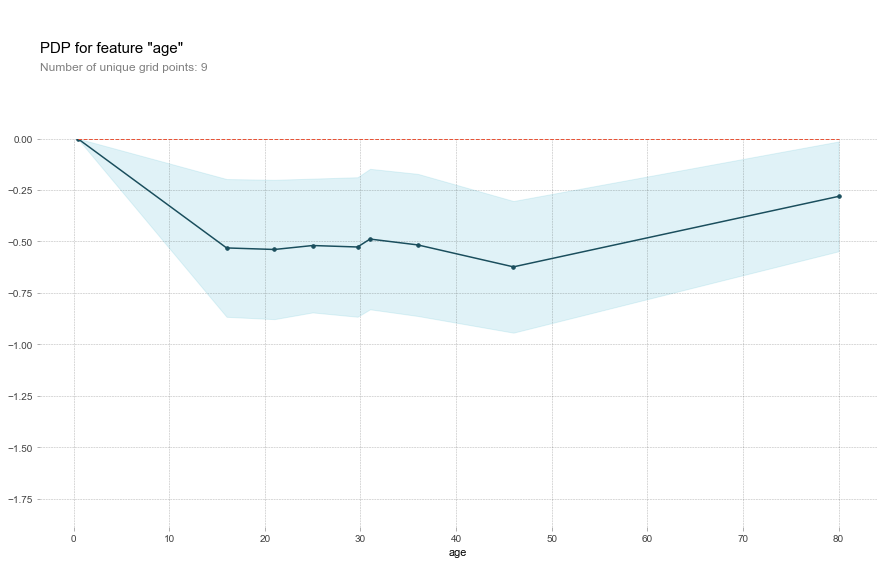

In [34]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature='age'
pdp_isolated = pdp_isolate(model=gb, dataset=X, model_features=X.columns, 
                           feature=feature)

pdp_plot(pdp_isolated, feature);

From [PDPbox documentation](https://pdpbox.readthedocs.io/en/latest/):


>**The common headache**: When using black box machine learning algorithms like random forest and boosting, it is hard to understand the relations between predictors and model outcome. For example, in terms of random forest, all we get is the feature importance. Although we can know which feature is significantly influencing the outcome based on the importance calculation, it really sucks that we don’t know in which direction it is influencing. And in most of the real cases, the effect is non-monotonic. We need some powerful tools to help understanding the complex relations between predictors and model prediction.

[Animation by Christoph Molnar](https://twitter.com/ChristophMolnar/status/1066398522608635904), author of [_Interpretable Machine Learning_](https://christophm.github.io/interpretable-ml-book/)

> Partial dependence plots show how a feature affects predictions of a Machine Learning model on average.
> 1. Define grid along feature
> 2. Model predictions at grid points
> 3. Line per data instance -> ICE (Individual Conditional Expectation) curve
> 4. Average curves to get a PDP (Partial Dependence Plot)

#### Compare Predictions

In [8]:
from sklearn.model_selection import cross_val_predict

y_pred_lr = cross_val_predict(lr, X, y, cv=5, n_jobs=-1)
y_pred_gb = cross_val_predict(gb, X, y, cv=5, n_jobs=-1)

preds = pd.DataFrame({'true': y, 'lr': y_pred_lr, 'gb': y_pred_gb})
              
gb_right = preds['gb'] == preds['true']
lr_wrong = preds['lr'] != preds['true']

len(preds[gb_right & lr_wrong]) / len(preds)

0.08417508417508418

In [9]:
preds[gb_right & lr_wrong].head()

,true,lr,gb
27,0,1,0
64,0,1,0
71,0,1,0
74,1,0,1
78,1,0,1


In [10]:
data_for_prediction = X.loc[27]

data_for_prediction

age          19
class         1
fare        263
female    False
Name: 27, dtype: object

#### Explain individual prediction

https://www.kaggle.com/dansbecker/shap-values

In [11]:
import shap

# Create object that can calculate shap values
explainer = shap.TreeExplainer(gb)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

ModuleNotFoundError: No module named 'shap'

# Lending Club

In [39]:
import category_encoders as ce
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

# Load data from https://www.kaggle.com/c/ds1-tree-ensembles/data
X_train = pd.read_csv('train_features.csv')
X_test = pd.read_csv('test_features.csv')
y_train = pd.read_csv('train_labels.csv')['charged_off']
sample_submission = pd.read_csv('sample_submission.csv')


def wrangle(X):
    X = X.copy()
    
    # Drop some columns
    X = X.drop(columns='id')  # id is random
    X = X.drop(columns=['member_id', 'url', 'desc'])  # All null
    X = X.drop(columns='title')  # Duplicative of purpose
    X = X.drop(columns='grade')  # Duplicative of sub_grade
    
    # Transform sub_grade from "A1" - "G5" to 1.1 - 7.5
    def wrangle_sub_grade(x):
        first_digit = ord(x[0]) - 64
        second_digit = int(x[1])
        return first_digit + second_digit/10
    
    X['sub_grade'] = X['sub_grade'].apply(wrangle_sub_grade)

    # Convert percentages from strings to floats
    X['int_rate'] = X['int_rate'].str.strip('%').astype(float)
    X['revol_util'] = X['revol_util'].str.strip('%').astype(float)
        
    # Transform earliest_cr_line to an integer: how many days it's been open
    X['earliest_cr_line'] = pd.to_datetime(X['earliest_cr_line'], infer_datetime_format=True)
    X['earliest_cr_line'] = pd.Timestamp.today() - X['earliest_cr_line']
    X['earliest_cr_line'] = X['earliest_cr_line'].dt.days
    
    # Create features for three employee titles: teacher, manager, owner
    X['emp_title'] = X['emp_title'].str.lower()
    X['emp_title_teacher'] = X['emp_title'].str.contains('teacher', na=False)
    X['emp_title_manager'] = X['emp_title'].str.contains('manager', na=False)
    X['emp_title_owner']   = X['emp_title'].str.contains('owner', na=False)
    
    # Drop categoricals with high cardinality
    X = X.drop(columns=['emp_title', 'zip_code'])
    
    # Transform features with many nulls to binary flags
    many_nulls = ['sec_app_mths_since_last_major_derog',
                  'sec_app_revol_util',
                  'sec_app_earliest_cr_line',
                  'sec_app_mort_acc',
                  'dti_joint',
                  'sec_app_collections_12_mths_ex_med',
                  'sec_app_chargeoff_within_12_mths',
                  'sec_app_num_rev_accts',
                  'sec_app_open_act_il',
                  'sec_app_open_acc',
                  'revol_bal_joint',
                  'annual_inc_joint',
                  'sec_app_inq_last_6mths',
                  'mths_since_last_record',
                  'mths_since_recent_bc_dlq',
                  'mths_since_last_major_derog',
                  'mths_since_recent_revol_delinq',
                  'mths_since_last_delinq',
                  'il_util',
                  'emp_length',
                  'mths_since_recent_inq',
                  'mo_sin_old_il_acct',
                  'mths_since_rcnt_il',
                  'num_tl_120dpd_2m',
                  'bc_util',
                  'percent_bc_gt_75',
                  'bc_open_to_buy',
                  'mths_since_recent_bc']

    for col in many_nulls:
        X[col] = X[col].isnull()
    
    # For features with few nulls, do mean imputation
    for col in X:
        if X[col].isnull().sum() > 0:
            X[col] = X[col].fillna(X[col].mean())
    
    # Return the wrangled dataframe
    return X


# Wrangle train and test in the same way
X_train = wrangle(X_train)
X_test  = wrangle(X_test)

In [40]:
%%time
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)
X_val = encoder.transform(X_val)
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred_proba = gb.predict_proba(X_val)[:,1]
print('Validation ROC AUC:', roc_auc_score(y_val, y_pred_proba))

Validation ROC AUC: 0.744114812226796
CPU times: user 12.3 s, sys: 145 ms, total: 12.5 s
Wall time: 10.3 s


### Partial Dependence Plot

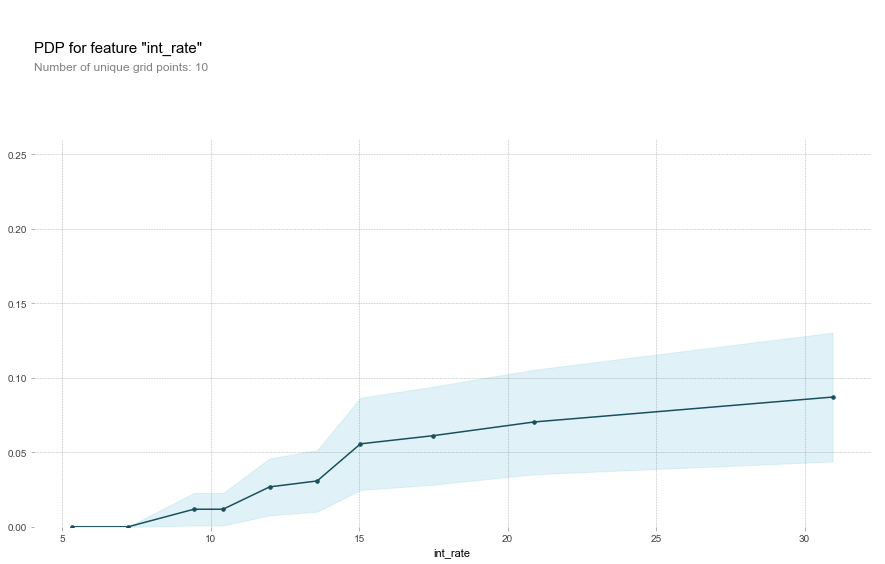

In [41]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature='int_rate'
pdp_isolated = pdp_isolate(model=gb, dataset=X_val, 
                           model_features=X_val.columns, feature=feature)
pdp_plot(pdp_isolated, feature);

### Individual predictions

In [43]:
import numpy as np
y_pred = (y_pred_proba >= 0.5).astype(int)
confidence = np.abs(y_pred_proba - 0.5)
preds = pd.DataFrame({'y_val': y_val, 'y_pred': y_pred, 
                      'y_pred_proba': y_pred_proba, 
                      'confidence': confidence})

preds.head()

,y_val,y_pred,y_pred_proba,confidence
33453,0,0,0.088536,0.411464
17996,0,0,0.088811,0.411189
37542,0,0,0.091326,0.408674
23642,0,0,0.070389,0.429611
7916,0,0,0.251518,0.248482


In [44]:
# True positives, with high confidence
preds[(y_val==1) & (y_pred==1)].sort_values(by='confidence', ascending=False).head()


,y_val,y_pred,y_pred_proba,confidence
17575,1,1,0.803640,0.303640
36032,1,1,0.784028,0.284028
24134,1,1,0.775933,0.275933
13765,1,1,0.765269,0.265269
24768,1,1,0.758786,0.258786


In [45]:
data_for_prediction = X_val.loc[17575]
explainer = shap.TreeExplainer(gb)
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)


In [46]:
# True negatives, with high confidence
preds[(y_val==0) & (y_pred==0)].sort_values(by='confidence', ascending=False).head()


,y_val,y_pred,y_pred_proba,confidence
29029,0,0,0.014921,0.485079
1778,0,0,0.017428,0.482572
23855,0,0,0.019234,0.480766
21604,0,0,0.019572,0.480428
32965,0,0,0.019754,0.480246


In [47]:
data_for_prediction = X_val.loc[1778]
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)


In [48]:
# False positives, with high (mistaken) confidence
preds[(y_val==0) & (y_pred==1)].sort_values(by='confidence', ascending=False).head()


,y_val,y_pred,y_pred_proba,confidence
33542,0,1,0.893203,0.393203
9560,0,1,0.712540,0.212540
15711,0,1,0.698724,0.198724
11486,0,1,0.696137,0.196137
34640,0,1,0.688740,0.188740


In [49]:
data_for_prediction = X_val.loc[33542]
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)



In [50]:
data_for_prediction

loan_amnt                                35000
funded_amnt                              35000
term                                         2
int_rate                                 26.77
installment                            1063.94
sub_grade                                  5.5
emp_length                               False
home_ownership                               3
annual_inc                               75000
purpose                                      3
addr_state                                   6
dti                                        0.4
delinq_2yrs                                  0
earliest_cr_line                          4826
inq_last_6mths                               1
mths_since_last_delinq                    True
mths_since_last_record                    True
open_acc                                     1
pub_rec                                      0
revol_bal                                  140
revol_util                                17.5
total_acc    

In [51]:
# False negatives, with high (mistaken) confidence
preds[(y_val==1) & (y_pred==0)].sort_values(by='confidence', ascending=False).head()


,y_val,y_pred,y_pred_proba,confidence
30492,1,0,0.021897,0.478103
22307,1,0,0.028285,0.471715
5743,1,0,0.029774,0.470226
23226,1,0,0.032316,0.467684
10300,1,0,0.036592,0.463408


In [52]:
data_for_prediction = X_val.loc[30492]
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)



In [53]:
# Most uncertain predictions (least confidence)
preds.sort_values(by='confidence', ascending=True).head()

,y_val,y_pred,y_pred_proba,confidence
33095,0,0,0.499459,0.000541
25617,1,0,0.498327,0.001673
17698,1,1,0.501813,0.001813
15538,1,1,0.501889,0.001889
36197,0,0,0.495927,0.004073


In [55]:
data_for_prediction = X_val.loc[33095]
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, 
                data_for_prediction)


In [56]:
data_for_prediction

loan_amnt                               10000
funded_amnt                             10000
term                                        2
int_rate                                30.65
installment                            327.54
sub_grade                                 6.4
emp_length                              False
home_ownership                              2
annual_inc                              37000
purpose                                     1
addr_state                                 12
dti                                     53.42
delinq_2yrs                                 1
earliest_cr_line                         4492
inq_last_6mths                              2
mths_since_last_delinq                  False
mths_since_last_record                  False
open_acc                                    8
pub_rec                                     1
revol_bal                                7370
revol_util                               63.5
total_acc                         